In [16]:
import os, random
import numpy as np
import torch


In [17]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [19]:
BASE_DIR = '.'
TRAIN_IMG_DIR  = os.path.join(BASE_DIR, "train", "images")
TRAIN_MASK_DIR = os.path.join(BASE_DIR, "train", "mask")
TEST_IMG_DIR   = os.path.join(BASE_DIR, "test", "images")

# EDA

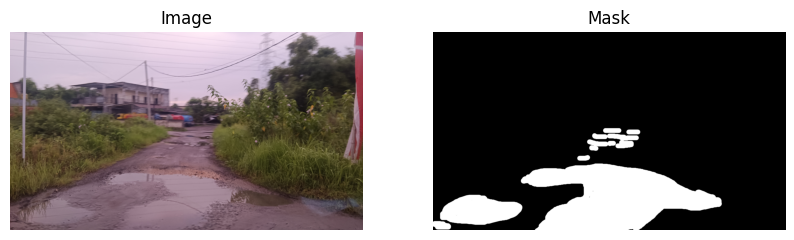

In [20]:
import cv2
import matplotlib.pyplot as plt

train_imgs = sorted([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith((".jpg",".jpeg",".png"))])

# untuk mapping nama mask dari nama image (karena perbedaan format file)
def img_to_mask_name(img_name: str) -> str:
    # default: train_001.jpg -> mask_001.png
    return img_name.replace("train_", "mask_").rsplit(".", 1)[0] + ".png"

img_name = train_imgs[0]
mask_name = img_to_mask_name(img_name)

img = cv2.imread(os.path.join(TRAIN_IMG_DIR, img_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(os.path.join(TRAIN_MASK_DIR, mask_name), cv2.IMREAD_GRAYSCALE)


plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
plt.show()


# Dataloader

In [21]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

IMG_SIZE = 384   
BATCH_SIZE = 2

class PotholeDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_names, size=384):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_names = img_names
        self.size = size

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        mask_name = img_name.replace("train_", "mask_").rsplit(".", 1)[0] + ".png"

        img = cv2.imread(f"{self.img_dir}/{img_name}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(f"{self.mask_dir}/{mask_name}", cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.size, self.size), interpolation=cv2.INTER_NEAREST)

        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2,0,1))  # CHW

        mask = (mask == 255).astype(np.float32)
        mask = np.expand_dims(mask, 0)  # (1,H,W)

        return torch.tensor(img), torch.tensor(mask)

all_imgs = sorted([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith((".jpg",".jpeg",".png"))])
train_imgs, val_imgs = train_test_split(all_imgs, test_size=0.2, random_state=SEED)

train_loader = DataLoader(PotholeDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_imgs, size=IMG_SIZE),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(PotholeDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, val_imgs, size=IMG_SIZE),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


Train batches: 199 Val batches: 50


# Membangun struktur  model : U-net + Loss Function (BCE + Dice)

In [22]:
import segmentation_models_pytorch as smp
import torch.nn as nn

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

bce = nn.BCEWithLogitsLoss()

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2*(probs*targets).sum(dim=(2,3))
    den = (probs+targets).sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()

def loss_fn(logits, targets):
    return bce(logits, targets) + dice_loss(logits, targets)

@torch.no_grad()
def dice_score(logits, targets, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    num = 2*(preds*targets).sum(dim=(2,3))
    den = (preds+targets).sum(dim=(2,3)) + eps
    return (num/den).mean().item()


# Iterasi Training Model (U-Net)

In [23]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

use_amp = (device == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

best_val = 0.0
EPOCHS = 5  # baseline dulu

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch} Train"):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = loss_fn(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    model.eval()
    val_d = 0.0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            val_d += dice_score(logits, y)

    val_d /= len(val_loader)
    print(f"Epoch {epoch} | train_loss={train_loss/len(train_loader):.4f} | val_dice={val_d:.4f}")

    if val_d > best_val:
        best_val = val_d
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved best_model.pth")


C:\Users\faizr\AppData\Local\Temp\ipykernel_12068\3564523676.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
Epoch 1 Train:   0%|          | 0/199 [00:00<?, ?it/s]

C:\Users\faizr\AppData\Local\Temp\ipykernel_12068\3564523676.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch 1 Val: 100%|██████████| 50/50 [00:07<00:00,  6.27it/s]


Epoch 1 | train_loss=1.0425 | val_dice=0.3198
✅ Saved best_model.pth


Epoch 2 Val: 100%|██████████| 50/50 [00:04<00:00, 11.69it/s]


Epoch 2 | train_loss=0.9097 | val_dice=0.4274
✅ Saved best_model.pth


Epoch 3 Val: 100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


Epoch 3 | train_loss=0.8689 | val_dice=0.4046


Epoch 4 Val: 100%|██████████| 50/50 [00:04<00:00, 12.04it/s]


Epoch 4 | train_loss=0.8243 | val_dice=0.4721
✅ Saved best_model.pth


Epoch 5 Val: 100%|██████████| 50/50 [00:04<00:00, 10.80it/s]

Epoch 5 | train_loss=0.7994 | val_dice=0.4974
✅ Saved best_model.pth


# RLE Encode (Mengubah hasil inferensi ke dalam format yang ditentukan)

In [24]:
import pandas as pd

def encode_rle(mask: np.ndarray, pos_value: int = 255) -> str:
    binary = (mask == pos_value).astype(np.uint8)
    pixels = binary.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[0::2]
    return " ".join(str(x) for x in runs)

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

def preprocess_img(img_rgb, size=IMG_SIZE):
    img = cv2.resize(img_rgb, (size, size), interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2,0,1))
    return img

@torch.no_grad()
def predict_mask255(img_rgb, thr=0.5):
    x = preprocess_img(img_rgb)
    x = torch.tensor(x).unsqueeze(0).to(device)
    logits = model(x)
    prob = torch.sigmoid(logits)[0,0].cpu().numpy()
    mask01 = (prob > thr).astype(np.uint8)
    return mask01 * 255

test_files = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith((".jpg",".jpeg",".png"))])

rows = []
for fname in tqdm(test_files, desc="Inference Test"):
    img = cv2.imread(f"{TEST_IMG_DIR}/{fname}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    pred_mask255 = predict_mask255(img, thr=0.5)
    rle = encode_rle(pred_mask255, pos_value=255)

    rows.append({"ImageId": fname, "rle": rle})

submission = pd.DataFrame(rows, columns=["ImageId", "rle"])
submission.to_csv("submission.csv", index=False)
submission.head()


Inference Test: 100%|██████████| 295/295 [00:13<00:00, 22.51it/s]


,ImageId,rle
0,test_001.jpg,15153 3 15537 4 15921 5 16305 6 16689 7 17073 ...
1,test_002.jpg,61621 4 62003 7 62385 10 62768 11 63151 12 635...
2,test_003.jpg,78627 2 78986 2 79009 6 79369 3 79393 6 79753 ...
3,test_004.jpg,35887 3 36270 5 36652 9 37036 11 37419 13 3780...
4,test_005.jpg,56597 2 56981 3 57364 4 57748 5 58132 5 58516 ...
